In [50]:
Shapes_open = {
    'Stick': {
        'z': {'nx': 6, 'ny': 6, 'nz': 25},
        'y': {'nx': 6, 'ny': 5, 'nz': 24},
        'x': {'nx': 5, 'ny': 6, 'nz': 24}
        },
    'Flat': {
        'z': {'nx': 16, 'ny': 16, 'nz': 5},
        'y': {'nx': 16, 'ny': 15, 'nz': 4},
        'x': {'nx': 15, 'ny': 16, 'nz': 4}
        },
    'Cube':{
        'z': {'nx': 10, 'ny': 10, 'nz': 11},
        'y': {'nx': 10, 'ny': 9, 'nz': 10},
        'x': {'nx': 9, 'ny': 10, 'nz': 10}
        }
    }

Shapes_border = {
    'Stick': {
        'z': {'nx': 6, 'ny': 6, 'nz': 25},
        'y': {'nx': 6, 'ny': 7, 'nz': 24},
        'x': {'nx': 7, 'ny': 6, 'nz': 24}
        },
    'Flat': {
        'z': {'nx': 16, 'ny': 16, 'nz': 5},
        'y': {'nx': 16, 'ny': 17, 'nz': 4},
        'x': {'nx': 17, 'ny': 16, 'nz': 4}
        },
    'Cube':{
        'z': {'nx': 10, 'ny': 10, 'nz': 11},
        'y': {'nx': 10, 'ny': 11, 'nz': 10},
        'x': {'nx': 11, 'ny': 10, 'nz': 10}
        }
    }

Shapes_anizotropic = {
    'Stick': {
        'z': {'nx': 6, 'ny': 6, 'nz': 25},
        },
    'Flat': {
        'z': {'nx': 16, 'ny': 16, 'nz': 5},
        },
    'Cube':{
        'z': {'nx': 10, 'ny': 10, 'nz': 11},
        }
    }

compessions = [1, 3, 10]



In [51]:
# Calculating currents in each ring on straight way for open structure

import numpy as np
from Straight_Method import solvesystem
from Geometry import Rectangle_packing
from Impedance_matrix import M_0
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params

import json

Inductance = {}
Omega =  np.linspace(0.95 * omega_0, 1.15 * omega_0, 100)
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures
Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
    'y': {'nz': Dz/2, 'ny': Dy, 'nx': Dx/2},
    'x': {'nz': Dz/2, 'ny': Dy/2, 'nx': Dx}
}
# Initial position of the first ring for each orientation

for name in Shapes_open:
    break
    Params['N'] = Shapes_open[name]
    # make 3d structure
    print(f'Make Rings: {name}, {Params["N"]}')
    Rings_4d ={}
    for pos in Params['N']:
        Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos)
    Rings = np.concatenate([Rings_4d[pos] for pos in Params['N']])
    Params['Number'] = len(Rings)
    Currents = solvesystem(Rings, M_0(Params), Omega, phi_0z=H_0z * mu_0 * np.pi * Radius ** 2, Inductance = Inductance)
    Currents['Shape'] = Shapes_open
    Nz, Ny, Nx = [Params['N'][pos][f'n{pos}'] for pos in Params['N']]
    Volume =  Nx * Ny * Nz * Dz * Dy * Dx
    P_0z = np.pi * Radius ** 2 /Volume/H_0z
    Currents['RealPolarisation'] = [P_0z * sum(i) for i in Currents['RealCurrents']]
    Currents['ImagPolarisation'] = [P_0z * sum(i) for i in Currents['ImagCurrents']]
    
    dims = ''.join([pos for pos in Params['N']])
    with open(f"Data/Form_Data/izotropic/{name}/S-Currents-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(Currents, f)

    exclude = ['RealCurrents', 'ImagCurrents']
    data = {key: value for key, value in Currents.items() if key not in exclude}
    with open(f"Data/Form_Data/izotropic/{name}/S-Data-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(data, f)

In [52]:
# Calculating currents in each ring on fft way for open structure
import numpy as np
from Fast_Method import solvesystem
from Geometry import Rectangle_packing
from Impedance_matrix import M_0
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params

import json

Inductance = {}
Omega =  np.linspace(61, 67, 1000) * 2 * np.pi * 1e6
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures

Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
# Initial position of the first ring for each orientation
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
    'y': {'nz': Dz/2, 'ny': Dy, 'nx': Dx/2},
    'x': {'nz': Dz/2, 'ny': Dy/2, 'nx': Dx}
}

for name in Shapes_open:
    break
    Params['N'] = Shapes_open[name]
    # make 3d structure
    print(f'\n Make rings: {name}, {Params["N"]}')
    Rings_4d ={}
    for pos in Params['N']:
        Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos).reshape(
                                                     Params['N'][pos]['nz'],
                                                     Params['N'][pos]['ny'],
                                                     Params['N'][pos]['nx'])
    Params['Number'] = np.sum([Rings_4d[pos].size for pos in Params['N']])
    Currents = solvesystem(Rings_4d, M_0(Params), Omega, phi_0z=H_0z * mu_0*np.pi * Radius ** 2, Inductance = Inductance, tol = 1e-2)

    Nz, Ny, Nx = [Params['N'][pos][f'n{pos}'] for pos in Params['N']]
    Volume =  Nx * Ny * Nz * Dz * Dy * Dx
    P_0z = np.pi * Radius ** 2 /Volume/H_0z
    Currents['Shape'] = Shapes_open
    Currents['RealPolarisation'] = [P_0z * sum(i) for i in Currents['RealCurrents']]
    Currents['ImagPolarisation'] = [P_0z * sum(i) for i in Currents['ImagCurrents']]
    dims = ''.join([pos for pos in Params['N']])
    with open(f"Data/Form_Data/izotropic/{name}/OpenCurrents-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(Currents, f)

    exclude = ['RealCurrents', 'ImagCurrents']
    data = {key: value for key, value in Currents.items() if key not in exclude}
    with open(f"Data/Form_Data/izotropic/{name}/OpenData-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(data, f)


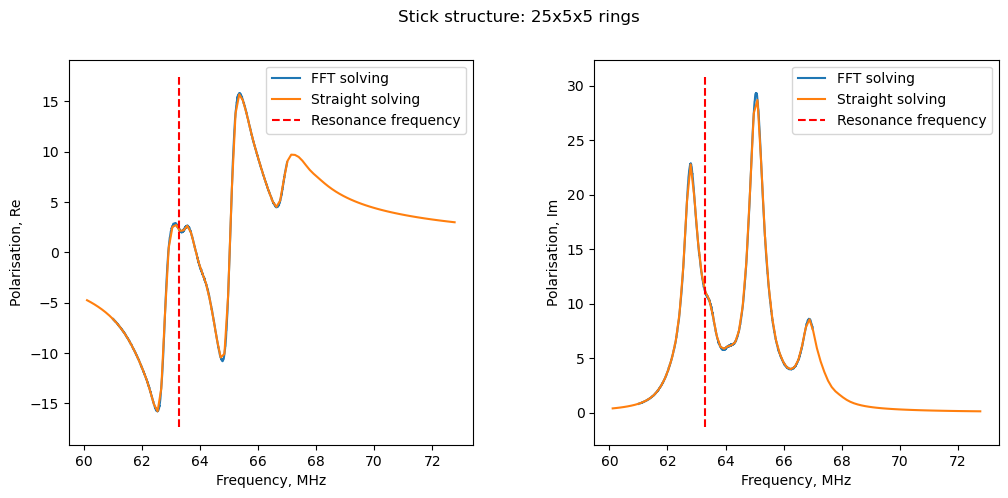

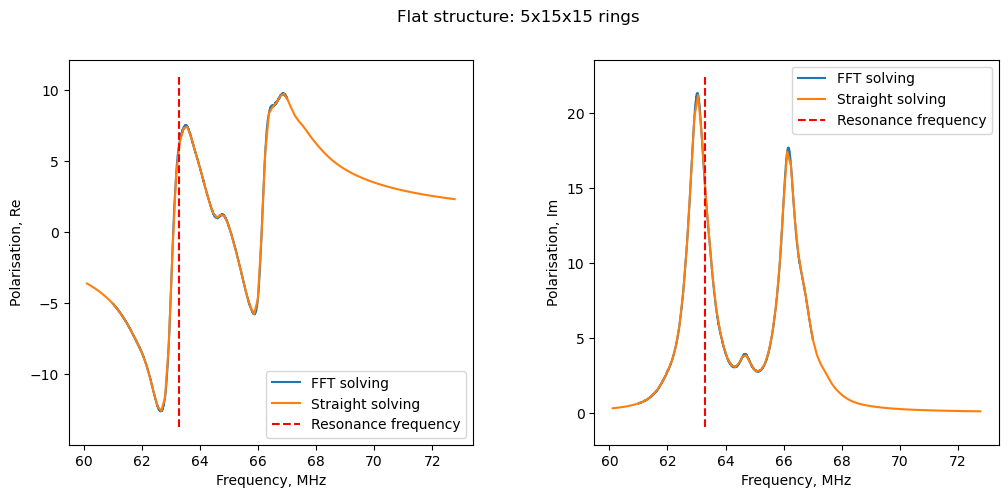

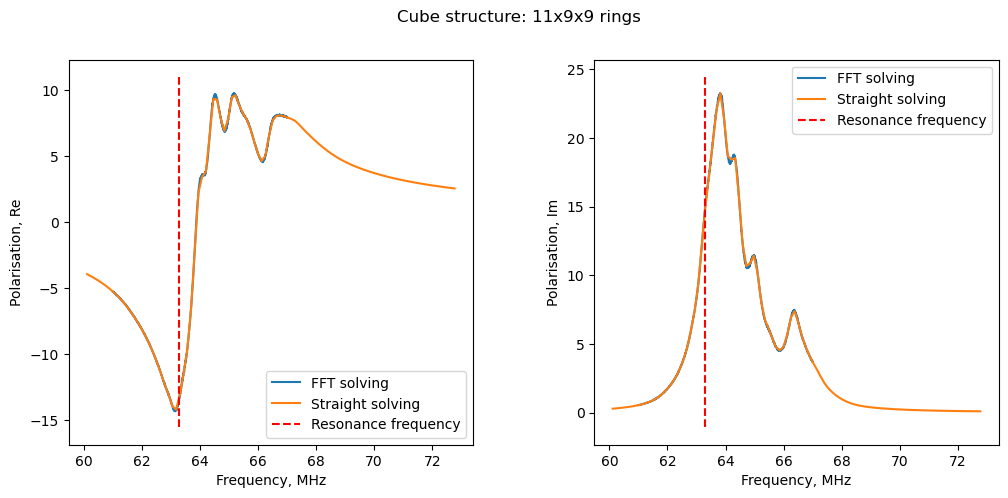

In [53]:
# Compare FFT and straight solving for open structure
import matplotlib.pyplot as plt

types = ["Stick", "Flat", "Cube"]
mu_0 = 4 * np.pi * 10**-7

for type, N in zip(types, Shapes_open):
    Nz, Ny, Nx = [Shapes_open[type][pos][f'n{pos}'] for pos in Shapes_open[type]]
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"{type} structure: {Nz}x{Ny}x{Nx} rings")

    with open(f"Data/Form_Data/izotropic/{type}/OpenData-zyx-{Nz}x{Ny}x{Nx}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])
    plt.subplot(121)
    

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'FFT solving')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'FFT solving')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    with open(f"Data/Form_Data/izotropic/{type}/S-Data-zyx-{Nz}x{Ny}x{Nx}", "r") as f:
        Data = json.load(f)
    
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])

    plt.subplot(121) 

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'Straight solving')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'Straight solving')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    plt.subplot(121)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()
    plt.subplot(122)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()

    plt.savefig(f'Plots/Report_images/Verify_{type}_{Nz}x{Ny}x{Nx}.png')
    plt.show()



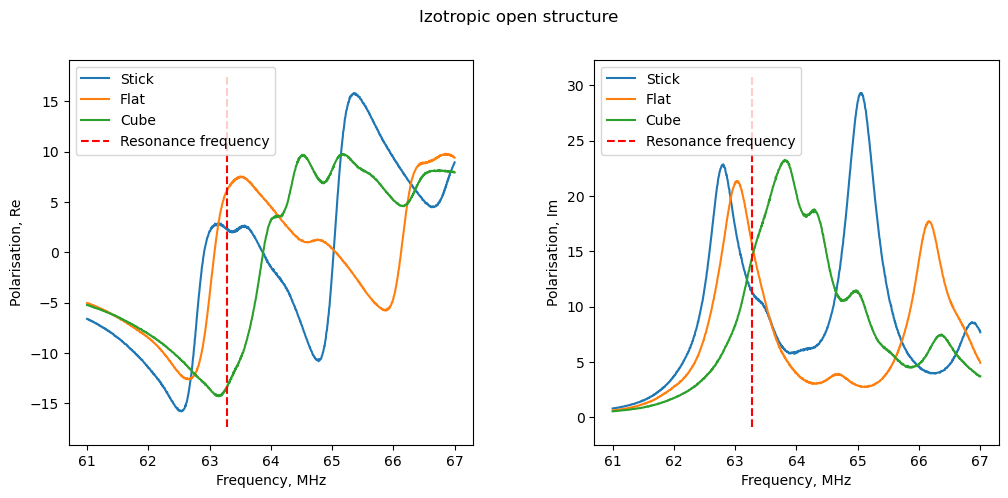

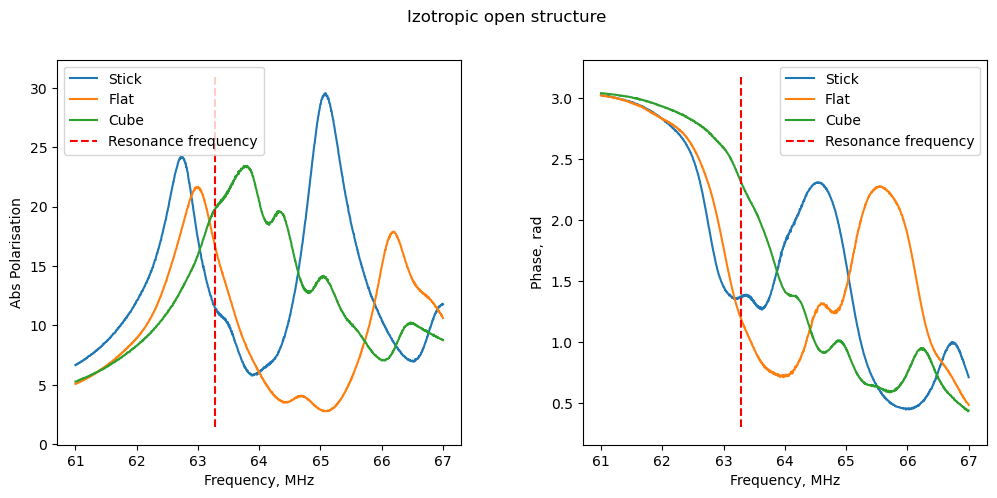

In [67]:
# Compare different shapes for open structure
import matplotlib.pyplot as plt

types = ["Stick", "Flat", "Cube"]
mu_0 = 4 * np.pi * 10**-7

plt.figure(figsize=(12, 5))
for type, N in zip(types, Shapes_open):
    Nz, Ny, Nx = [Shapes_open[type][pos][f'n{pos}'] for pos in Shapes_open[type]]
    #plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"Izotropic open structure")

    with open(f"Data/Form_Data/izotropic/{type}/OpenData-zyx-{Nz}x{Ny}x{Nx}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])
    plt.subplot(121)
    

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = type)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = type)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

plt.subplot(121)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.subplot(122)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()

plt.savefig(f"Plots/Report_images/FormIzoOpenPolarisationImRe.png")
plt.show()

plt.figure(figsize=(12, 5))
for type, N in zip(types, Shapes_open):
    Nz, Ny, Nx = [Shapes_open[type][pos][f'n{pos}'] for pos in Shapes_open[type]]
    #plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"Izotropic open structure")

    with open(f"Data/Form_Data/izotropic/{type}/OpenData-zyx-{Nz}x{Ny}x{Nx}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])
    Polarisation = RealPolarisation + 1j * ImagPolarisation
    AbsPolarisation = np.abs(Polarisation)
    PhasePolarisation = np.angle(Polarisation)

    plt.subplot(121)

    plt.plot(Omega/2/np.pi/10**6, AbsPolarisation, label = type)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Abs Polarisation")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, PhasePolarisation, label = type)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Phase, rad")

plt.subplot(121)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.subplot(122)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()

plt.savefig(f"Plots/Report_images/FormIzoOpenPolarisationAbsPhase.png")
plt.show()

In [55]:
# Calculating currents in each ring on fft way for border structure
import numpy as np
from Fast_Method import solvesystem
from Geometry import Rectangle_packing
from Impedance_matrix import M_0
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params

import json

Inductance = {}
Omega =  np.linspace(61, 67, 1000) * 2 * np.pi * 1e6
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures

Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
# Initial position of the first ring for each orientation
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
    'y': {'nz': Dz/2, 'ny': 0, 'nx': Dx/2},
    'x': {'nz': Dz/2, 'ny': Dy/2, 'nx': 0}
}

for name in Shapes_border:
    break
    Params['N'] = Shapes_border[name]
    # make 3d structure
    print(f'\n Make rings: {name}, {Params["N"]}')
    Rings_4d ={}
    for pos in Params['N']:
        Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos).reshape(
                                                     Params['N'][pos]['nz'],
                                                     Params['N'][pos]['ny'],
                                                     Params['N'][pos]['nx'])
    Params['Number'] = np.sum([Rings_4d[pos].size for pos in Params['N']])
    Currents = solvesystem(Rings_4d, M_0(Params), Omega, phi_0z=H_0z * mu_0*np.pi * Radius ** 2, Inductance = Inductance, tol = 1e-2)

    Nz, Ny, Nx = [Params['N'][pos][f'n{pos}'] for pos in Params['N']]
    Volume =  Nx * Ny * Nz * Dz * Dy * Dx
    P_0z = np.pi * Radius ** 2 /Volume/H_0z
    Currents['Shape'] = Shapes_border
    Currents['RealPolarisation'] = [P_0z * sum(i) for i in Currents['RealCurrents']]
    Currents['ImagPolarisation'] = [P_0z * sum(i) for i in Currents['ImagCurrents']]
    dims = ''.join([pos for pos in Params['N']])
    with open(f"Data/Form_Data/izotropic/{name}/BorderCurrents-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(Currents, f)

    exclude = ['RealCurrents', 'ImagCurrents']
    data = {key: value for key, value in Currents.items() if key not in exclude}
    with open(f"Data/Form_Data/izotropic/{name}/BorderData-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(data, f)


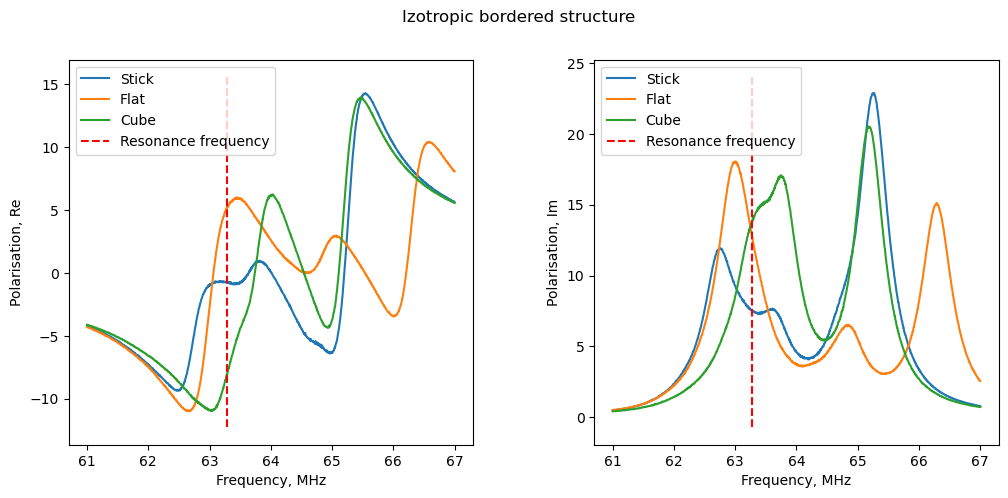

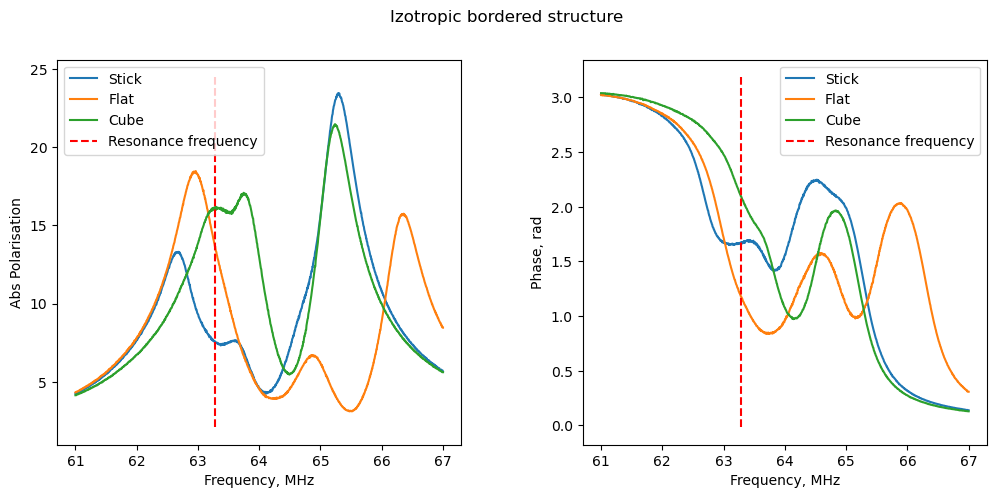

In [66]:
# Compare different shapes in border structure
import matplotlib.pyplot as plt

types = ["Stick", "Flat", "Cube"]
mu_0 = 4 * np.pi * 10**-7

plt.figure(figsize=(12, 5))
for type, N in zip(types, Shapes_border):
    Nz, Ny, Nx = [Shapes_border[type][pos][f'n{pos}'] for pos in Shapes_border[type]]
    #plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"Izotropic bordered structure")

    with open(f"Data/Form_Data/izotropic/{type}/BorderData-zyx-{Nz}x{Ny}x{Nx}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])
    plt.subplot(121)
    

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = type)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = type)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

plt.subplot(121)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.subplot(122)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()

plt.savefig(f"Plots/Report_images/FormIzoBorderPolarisationImRe.png")
plt.show()

plt.figure(figsize=(12, 5))
for type, N in zip(types, Shapes_border):
    Nz, Ny, Nx = [Shapes_border[type][pos][f'n{pos}'] for pos in Shapes_border[type]]
    #plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"Izotropic bordered structure")

    with open(f"Data/Form_Data/izotropic/{type}/BorderData-zyx-{Nz}x{Ny}x{Nx}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])
    Polarisation = RealPolarisation + 1j * ImagPolarisation
    AbsPolarisation = np.abs(Polarisation)
    PhasePolarisation = np.angle(Polarisation)

    plt.subplot(121)

    plt.plot(Omega/2/np.pi/10**6, AbsPolarisation, label = type)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Abs Polarisation")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, PhasePolarisation, label = type)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Phase, rad")

plt.subplot(121)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.subplot(122)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()

plt.savefig(f"Plots/Report_images/FormIzoBorderPolarisationAbsPhase.png")
plt.show()

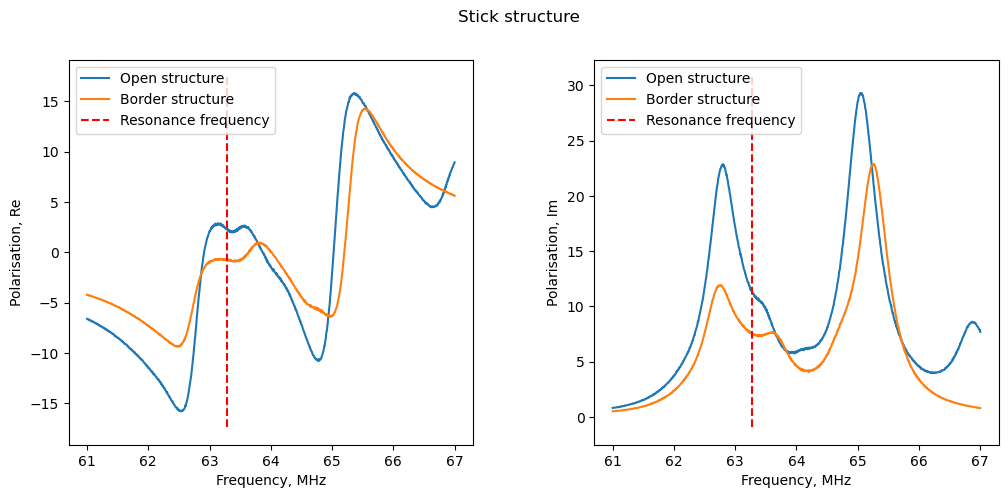

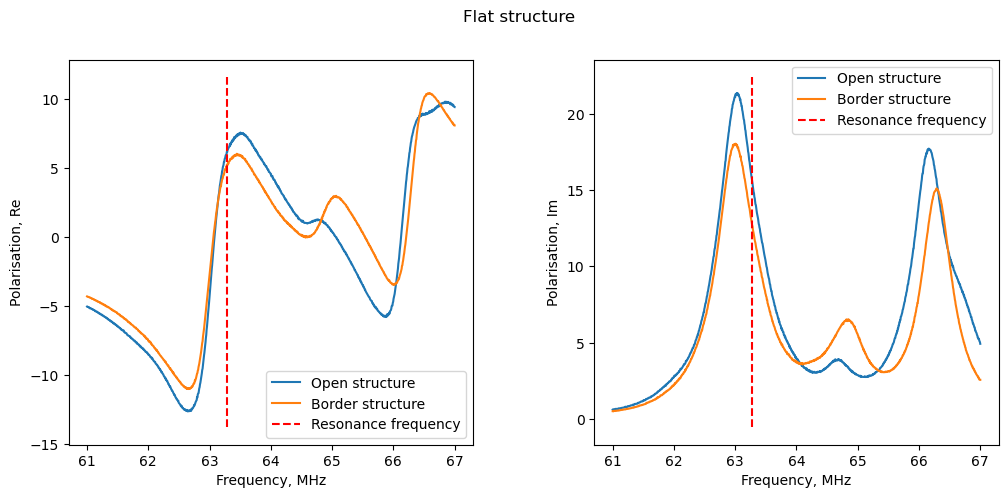

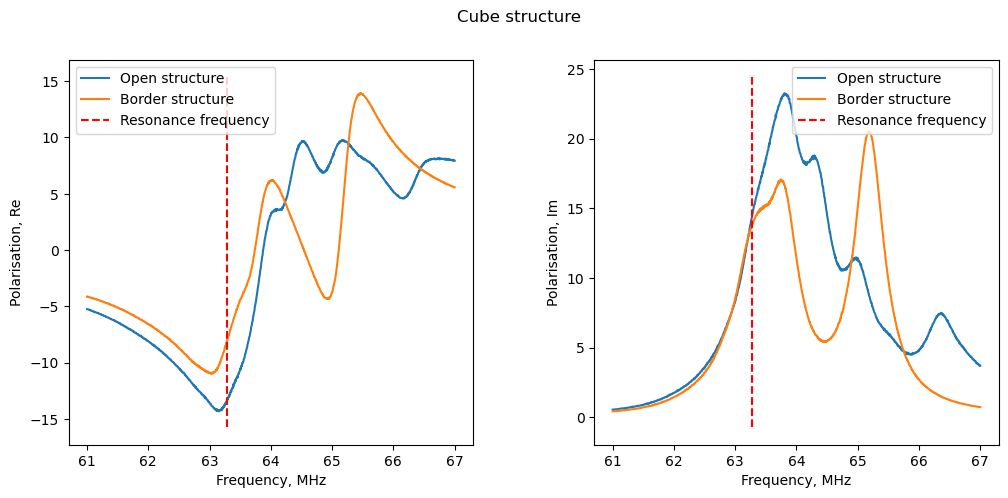

In [57]:
# Compare different border and open structures

import matplotlib.pyplot as plt

types = ["Stick", "Flat", "Cube"]
mu_0 = 4 * np.pi * 10**-7

for type, N_open, N_border in zip(types, Shapes_open, Shapes_border):
    Nz_open, Ny_open, Nx_open = [Shapes_open[type][pos][f'n{pos}'] for pos in Shapes_open[type]]
    Nz_border, Ny_border, Nx_border = [Shapes_border[type][pos][f'n{pos}'] for pos in Shapes_border[type]]

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"{type} structure")

    with open(f"Data/Form_Data/izotropic/{type}/OpenData-zyx-{Nz_open}x{Ny_open}x{Nx_open}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])
    plt.subplot(121)
    

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'Open structure')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'Open structure')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    with open(f"Data/Form_Data/izotropic/{type}/BorderData-zyx-{Nz_border}x{Ny_border}x{Nx_border}", "r") as f:
        Data = json.load(f)
    
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])

    plt.subplot(121) 

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'Border structure')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'Border structure')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    plt.subplot(121)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()
    plt.subplot(122)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()

    plt.savefig(f'Plots/Report_images/Compare_border_{type}.png')
    plt.show()

In [58]:
# Calculating currents in each ring on fft way for anizotropic structure
import numpy as np
from Fast_Method import solvesystem
from Geometry import Rectangle_packing
from Impedance_matrix import M_0
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params

import json

Inductance = {}
Omega =  np.linspace(40, 100, 10000) * 2 * np.pi * 1e6
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures

Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
# Initial position of the first ring for each orientation
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
}
compessions = [1, 3, 10]
for compession in compessions:
    for name in Shapes_anizotropic:
        break
        Params['N'] = Shapes_anizotropic[name]
        Params['Dz'] = Dz / compession
        # make 3d structure
        print(f'\n Make rings: {name}, {Params["N"]}, compression: {compession}')
        Rings_4d ={}
        for pos in Params['N']:
            Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos).reshape(
                                                         Params['N'][pos]['nz'],
                                                         Params['N'][pos]['ny'],
                                                         Params['N'][pos]['nx'])
        Params['Number'] = np.sum([Rings_4d[pos].size for pos in Params['N']])

        Currents = solvesystem(Rings_4d, M_0(Params), Omega, phi_0z=H_0z * mu_0*np.pi * Radius ** 2, Inductance = Inductance, tol = 1e-5)

        Nz, Ny, Nx = Params['N']['z'].values()
        Volume =  Nx * Ny * Nz * Dz * Dy * Dx
        P_0z = np.pi * Radius ** 2 /Volume/H_0z
        Currents['Shape'] = Shapes_anizotropic
        Currents['RealPolarisation'] = [P_0z * sum(i) for i in Currents['RealCurrents']]
        Currents['ImagPolarisation'] = [P_0z * sum(i) for i in Currents['ImagCurrents']]
        dims = ''.join([pos for pos in Params['N']])
        with open(f"Data/Form_Data/anizotropic/{name}/{compession}Currents-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
            json.dump(Currents, f)

        exclude = ['RealCurrents', 'ImagCurrents']
        data = {key: value for key, value in Currents.items() if key not in exclude}
        with open(f"Data/Form_Data/anizotropic/{name}/{compession}Data-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
            json.dump(data, f)

In [59]:
# Compare different izotropic and anizotropic structures

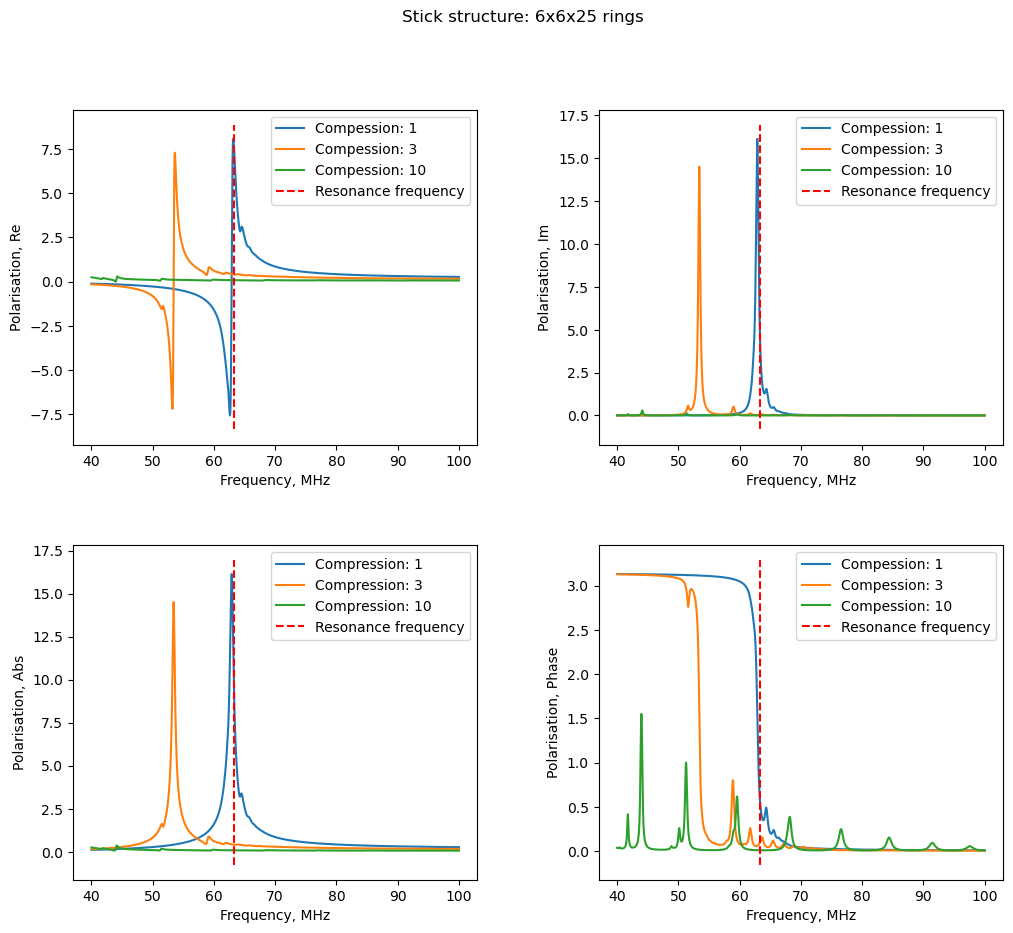

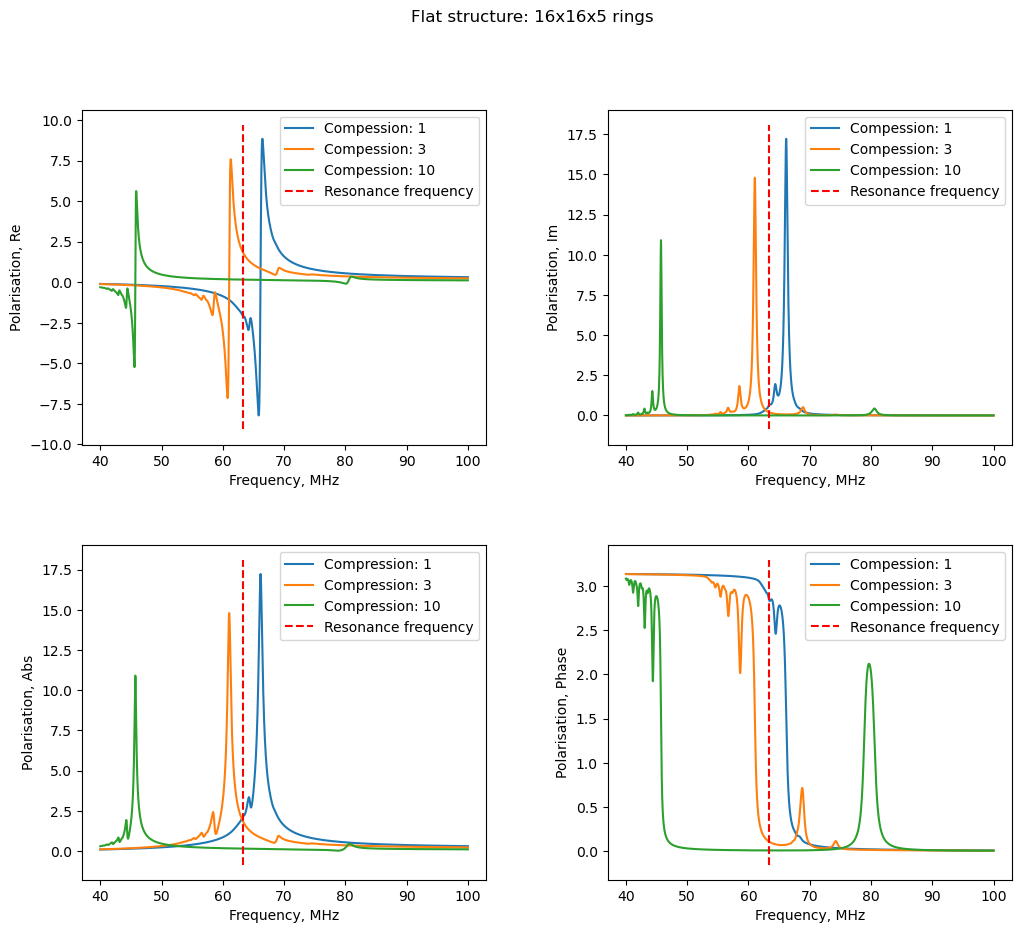

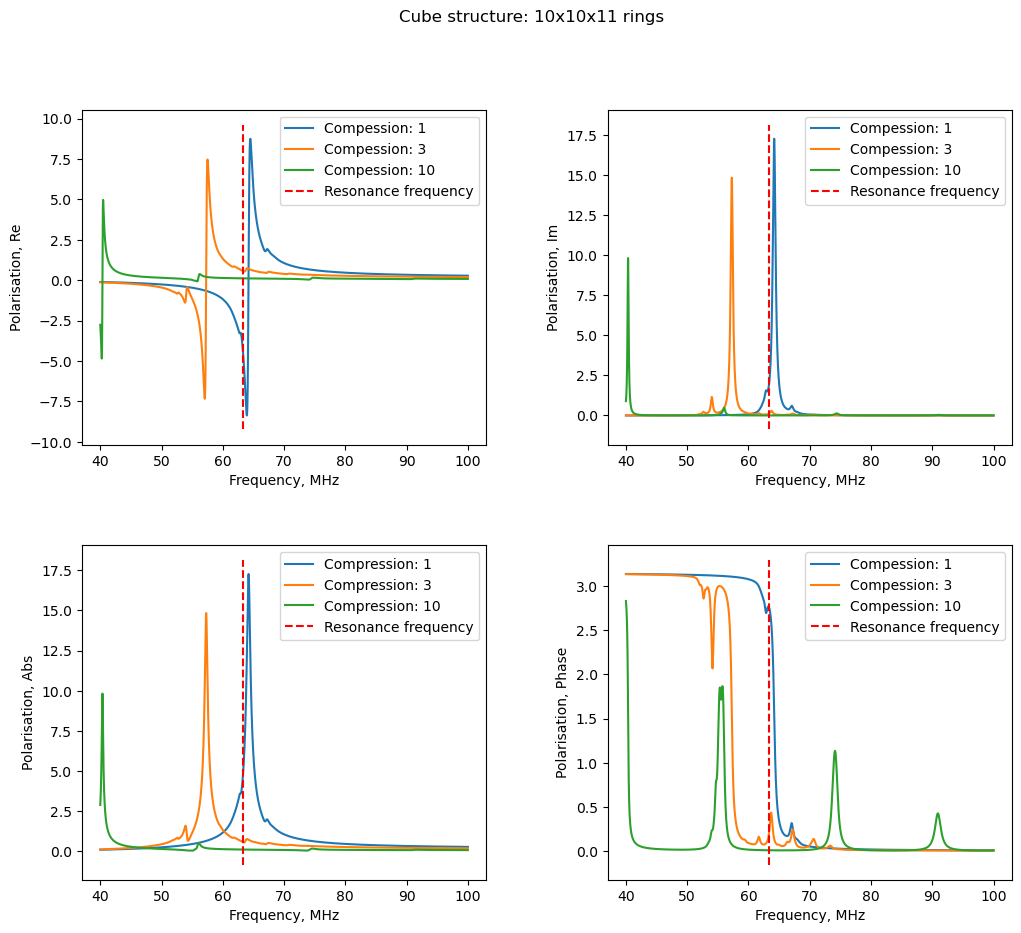

In [60]:
#Compare different compession for anizotropic structure

# Compare different border and open structures

import matplotlib.pyplot as plt

types = ["Stick", "Flat", "Cube"]
mu_0 = 4 * np.pi * 10**-7

for type in types:
    Nz, Ny, Nx = [Shapes_open[type][pos][f'n{pos}'] for pos in Shapes_open[type]]
    plt.figure(figsize=(12, 10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"Anizotropic structure, FFT Solving")

    with open(f"Data/Form_Data/izotropic/{type}/OpenData-zyx-{Nz}x{Ny}x{Nx}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])
    Polarisation = RealPolarisation + 1j * ImagPolarisation
    AbsPolarisation = np.abs(Polarisation)
    PhasePolarisation = np.angle(Polarisation)
    plt.subplot(221)
    

    # plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'Izotropic')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(222)
    #plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'Izotropic')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    for compession in compessions:
        Nz, Ny, Nx = Shapes_anizotropic[type]['z'].values()

        plt.subplots_adjust(wspace=0.3, hspace=0.3)  
        plt.suptitle(f"{type} structure: {Nz}x{Ny}x{Nx} rings")

        with open(f"Data/Form_Data/anizotropic/{type}/{compession}Data-z-{Nz}x{Ny}x{Nx}", "r") as f:
            Data = json.load(f)
        Omega = np.array(Data["Omega"])
        RealPolarisation = np.array(Data["RealPolarisation"])
        ImagPolarisation = np.array(Data["ImagPolarisation"])
        Polarisation = RealPolarisation + 1j * ImagPolarisation
        AbsPolarisation = np.abs(Polarisation)
        PhasePolarisation = np.angle(Polarisation)
        plt.subplot(223)


        plt.plot(Omega/2/np.pi/10**6, AbsPolarisation, label = f'Compression: {compession}')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Abs")

        plt.subplot(224)
        plt.plot(Omega/2/np.pi/10**6, PhasePolarisation, label = f'Compession: {compession}')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Phase")

        plt.subplot(221)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'Compession: {compession}')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(222)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'Compession: {compession}')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")

    plt.subplot(221)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()
    plt.subplot(222)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()

    plt.subplot(223)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()
    plt.subplot(224)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()

    plt.savefig(f'Plots/Report_images/Compress_{type}_{Nz}x{Ny}x{Nx}.png')
    plt.show()

In [61]:
# Compare different shapes for anizotropic structure

93 93 Stick


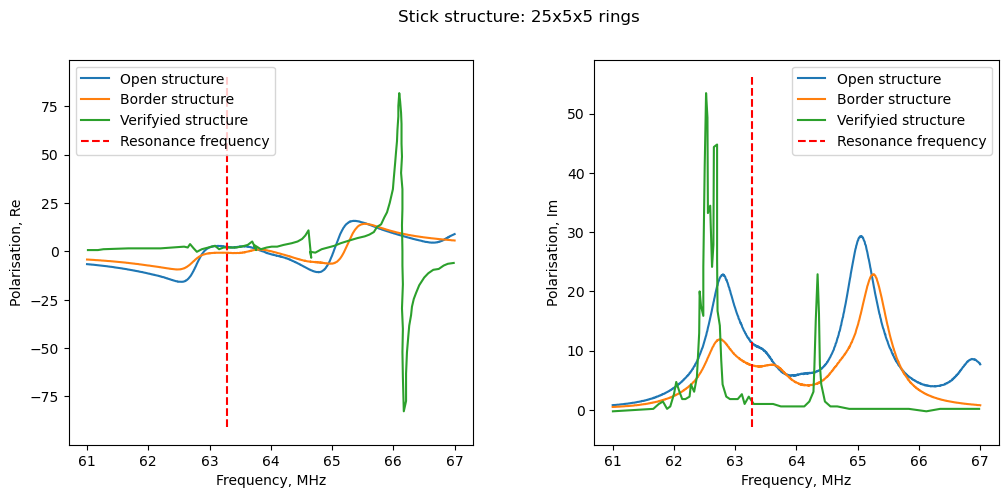

85 85 Flat


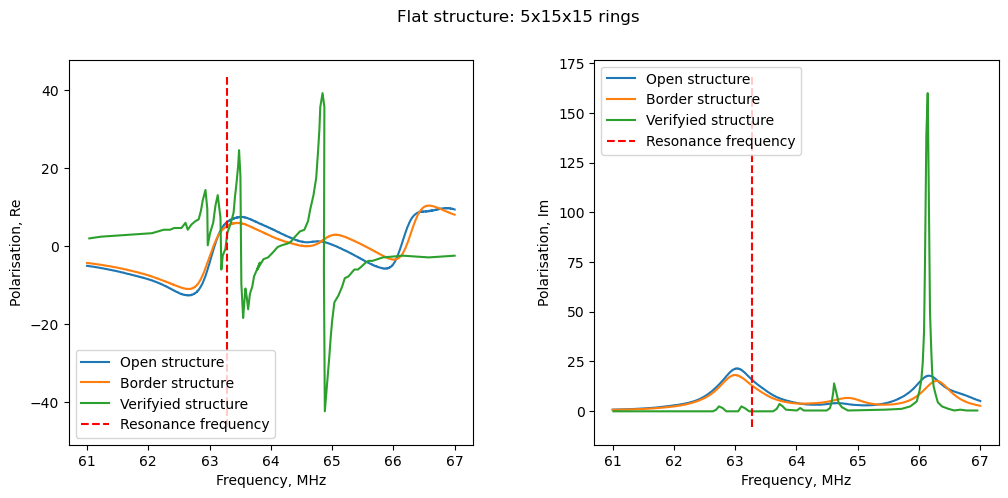

83 83 Cube


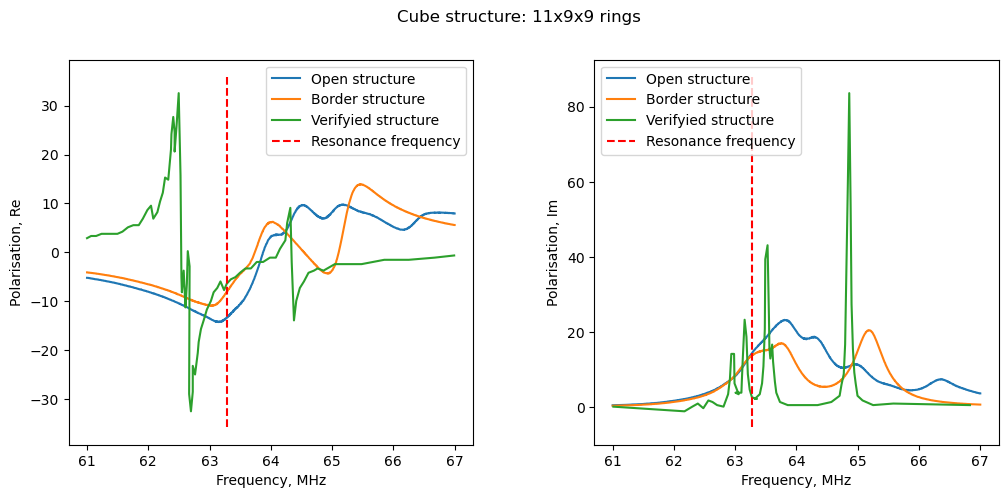

In [62]:
# Getting data from origin plots

Michle_RealOmega = {}
Michle_RealPolarisation = {}
Michle_ImagOmega = {}
Michle_ImagPolarisation = {}

Michle_RealOmega['Stick'] = [61.01481481481481, 61.096296296296295, 61.17777777777778, 61.266666666666666, 61.67407407407407, 62.2, 62.58518518518518, 62.644444444444446, 62.681481481481484, 62.74074074074074, 62.79259259259259, 62.87407407407407, 63.08888888888889, 63.15555555555556, 63.22962962962963, 63.318518518518516, 63.42962962962963, 63.51851851851852, 63.62222222222222, 63.696296296296296, 63.762962962962966, 63.72592592592593, 63.837037037037035, 63.93333333333333, 64.01481481481481, 64.1037037037037, 64.2074074074074, 64.34074074074074, 64.43703703703704, 64.5111111111111, 64.56296296296296, 64.61481481481482, 64.65925925925926, 64.64444444444445, 64.72592592592592, 64.82962962962964, 64.93333333333334, 65.03703703703704, 65.14074074074074, 65.27407407407408, 65.41481481481482, 65.53333333333333, 65.60740740740741, 65.68148148148148, 65.73333333333333, 65.8, 65.85185185185185, 65.8962962962963, 65.94074074074074, 65.99259259259259, 66.00740740740741, 66.02962962962962, 66.04444444444445, 66.05925925925926, 66.06666666666666, 66.08148148148148, 66.08148148148148, 66.0962962962963, 66.11111111111111, 66.12592592592593, 66.13333333333334, 66.13333333333334, 66.13333333333334, 66.14074074074074, 66.12592592592593, 66.14814814814815, 66.14814814814815, 66.14074074074074, 66.14814814814815, 66.14814814814815, 66.15555555555555, 66.14074074074074, 66.15555555555555, 66.14814814814815, 66.15555555555555, 66.17037037037036, 66.2074074074074, 66.2074074074074, 66.22222222222223, 66.24444444444444, 66.25925925925927, 66.28888888888889, 66.3037037037037, 66.33333333333333, 66.37037037037037, 66.42222222222222, 66.5037037037037, 66.57037037037037, 66.65185185185186, 66.74074074074073, 66.82222222222222, 66.88888888888889, 66.98518518518519]
Michle_RealPolarisation['Stick'] = [0.6648199445983352, 0.6648199445983352, 0.6648199445983352, 1.10803324099723, 1.5512465373961248, 1.5512465373961248, 2.4376731301939145, 1.9944598337950197, 3.767313019390585, 1.5512465373961248, -0.22160664819944031, 1.10803324099723, 2.880886426592795, 1.10803324099723, 1.9944598337950197, 1.9944598337950197, 1.9944598337950197, 2.4376731301939145, 3.32409972299169, 5.096952908587255, 0.6648199445983352, 3.32409972299169, 1.10803324099723, 1.9944598337950197, 2.4376731301939145, 2.4376731301939145, 3.32409972299169, 4.21052631578948, 5.096952908587255, 6.42659279778394, 8.199445983379505, 10.85872576177286, -3.32409972299169, -0.22160664819944031, -0.6648199445983352, 1.10803324099723, 1.9944598337950197, 2.880886426592795, 4.21052631578948, 5.54016620498615, 6.8698060941828345, 7.75623268698061, 8.6426592797784, 9.97229916897507, 12.631578947368425, 13.961218836565095, 17.506925207756233, 20.166204986149587, 25.041551246537395, 32.13296398891967, 37.89473684210527, 45.87257617728532, 51.634349030470915, 56.95290858725762, 62.714681440443215, 69.80609418282549, 75.12465373961219, 81.77285318559557, 77.34072022160665, 71.57894736842105, 65.81717451523545, 60.94182825484765, 55.62326869806094, 48.97506925207756, 40.554016620498615, 32.13296398891967, 21.939058171745152, 13.5180055401662, 0.22160664819945453, -7.313019390581715, -17.063711911357345, -29.473684210526315, -40.11080332409972, -52.07756232686981, -64.93074792243766, -82.65927977839334, -77.34072022160663, -63.15789473684211, -52.07756232686981, -43.65650969529085, -38.337950138504155, -33.019390581717445, -28.587257617728525, -24.5983379501385, -21.49584487534625, -17.506925207756225, -13.5180055401662, -11.30193905817174, -9.529085872576175, -9.08587257617728, -7.313019390581715, -6.4265927977839254, -5.983379501385045]

Michle_RealOmega['Flat'] = [61.03703703703704, 61.22962962962963, 62.05925925925926, 62.25185185185185, 62.355555555555554, 62.422222222222224, 62.54074074074074, 62.60740740740741, 62.644444444444446, 62.7037037037037, 62.77037037037037, 62.82222222222222, 62.85925925925926, 62.888888888888886, 62.93333333333333, 62.96296296296296, 62.97037037037037, 63.007407407407406, 63.05925925925926, 63.096296296296295, 63.13333333333333, 63.17777777777778, 63.19259259259259, 63.214814814814815, 63.25925925925926, 63.28888888888889, 63.34814814814815, 63.39259259259259, 63.41481481481482, 63.43703703703704, 63.46666666666667, 63.48148148148148, 63.50370370370371, 63.51851851851852, 63.54814814814815, 63.56296296296296, 63.58518518518518, 63.60740740740741, 63.62962962962963, 63.65925925925926, 63.696296296296296, 63.72592592592593, 63.82222222222222, 63.77777777777778, 63.88148148148148, 63.955555555555556, 64.03703703703704, 64.11111111111111, 64.17777777777778, 64.27407407407408, 64.32592592592593, 64.37037037037037, 64.42222222222222, 64.47407407407407, 64.54814814814814, 64.60740740740741, 64.64444444444445, 64.6962962962963, 64.74074074074075, 64.77037037037037, 64.7925925925926, 64.80740740740741, 64.84444444444445, 64.87407407407407, 64.86666666666666, 64.88148148148149, 64.91851851851852, 64.95555555555555, 64.97777777777777, 65, 65.03703703703704, 65.1037037037037, 65.16296296296296, 65.2074074074074, 65.26666666666667, 65.36296296296297, 65.42222222222222, 65.4888888888889, 65.54814814814814, 65.5925925925926, 65.65925925925926, 65.82962962962964, 66.15555555555555, 66.57777777777778, 67]
Michle_RealPolarisation['Flat'] = [1.9944598337950197, 2.4376731301939145, 3.32409972299169, 4.21052631578948, 4.21052631578948, 4.6537396121883745, 4.6537396121883745, 5.983379501385045, 4.21052631578948, 5.54016620498615, 6.42659279778394, 6.8698060941828345, 9.08587257617728, 11.745152354570635, 14.40443213296399, 9.529085872576175, 0.22160664819945453, 3.32409972299169, 5.983379501385045, 10.415512465373965, 13.07479224376732, 7.313019390581715, -5.983379501385045, -2.4376731301939003, -0.6648199445983352, 3.32409972299169, 5.983379501385045, 8.6426592797784, 12.631578947368425, 15.73407202216066, 20.609418282548475, 24.598337950138507, 17.950138504155127, -9.529085872576175, -18.393351800554015, -15.290858725761765, -10.858725761772845, -13.074792243767305, -16.177285318559555, -12.18836565096953, -10.415512465373965, -7.75623268698061, -4.2105263157894655, -5.983379501385045, -3.32409972299169, -2.880886426592795, -1.5512465373961248, -0.22160664819944031, 0.22160664819945453, 0.6648199445983352, 1.10803324099723, 1.9944598337950197, 2.880886426592795, 3.767313019390585, 4.21052631578948, 6.42659279778394, 9.529085872576175, 13.07479224376732, 17.506925207756233, 24.155124653739612, 29.91689750692521, 35.67867036011081, 39.22437673130194, 35.67867036011081, -6.4265927977839254, -42.32686980609418, -35.235457063711905, -28.14404432132963, -23.26869806094183, -19.27977839335179, -14.40443213296399, -12.631578947368425, -10.415512465373965, -8.199445983379505, -7.75623268698061, -5.983379501385045, -5.983379501385045, -5.096952908587255, -4.2105263157894655, -3.767313019390585, -3.767313019390585, -2.880886426592795, -2.4376731301939003, -2.880886426592795, -2.4376731301939003]

Michle_RealOmega['Cube'] = [61, 61.06666666666667, 61.148148148148145, 61.237037037037034, 61.32592592592593, 61.407407407407405, 61.49629629629629, 61.577777777777776, 61.666666666666664, 61.75555555555555, 61.84444444444444, 61.91111111111111, 61.98518518518519, 62.044444444444444, 62.08148148148148, 62.148148148148145, 62.19259259259259, 62.237037037037034, 62.27407407407407, 62.32592592592593, 62.34814814814815, 62.370370370370374, 62.37777777777778, 62.407407407407405, 62.42962962962963, 62.42962962962963, 62.45925925925926, 62.49629629629629, 62.525925925925925, 62.54074074074074, 62.54814814814815, 62.577777777777776, 62.592592592592595, 62.60740740740741, 62.629629629629626, 62.644444444444446, 62.67407407407407, 62.666666666666664, 62.696296296296296, 62.72592592592593, 62.72592592592593, 62.762962962962966, 62.80740740740741, 62.82222222222222, 62.85925925925926, 62.903703703703705, 62.955555555555556, 63.022222222222226, 63.06666666666667, 63.12592592592593, 63.17777777777778, 63.237037037037034, 63.28148148148148, 63.34814814814815, 63.34814814814815, 63.422222222222224, 63.49629629629629, 63.58518518518518, 63.67407407407407, 63.77037037037037, 63.87407407407407, 63.98518518518519, 64.08148148148148, 64.14814814814815, 64.23703703703704, 64.26666666666667, 64.31851851851852, 64.34074074074074, 64.37777777777778, 64.41481481481482, 64.47407407407407, 64.54074074074074, 64.61481481481482, 64.70370370370371, 64.76296296296296, 64.85925925925926, 65.04444444444445, 65.48148148148148, 65.85185185185185, 66.25185185185185, 66.67407407407407, 66.67407407407407, 66.99259259259259]
Michle_RealPolarisation['Cube'] = [2.880886426592795, 3.32409972299169, 3.32409972299169, 3.767313019390585, 3.767313019390585, 3.767313019390585, 3.767313019390585, 4.21052631578948, 5.096952908587255, 5.54016620498615, 5.54016620498615, 6.8698060941828345, 8.6426592797784, 9.529085872576175, 6.8698060941828345, 8.199445983379505, 10.415512465373965, 12.18836565096953, 15.29085872576178, 14.847645429362885, 17.950138504155127, 21.05263157894737, 24.155124653739612, 27.70083102493075, 24.598337950138507, 20.609418282548475, 25.48476454293629, 32.57617728531856, 15.73407202216066, -5.096952908587255, -8.199445983379505, -3.767313019390585, -7.75623268698061, -11.30193905817174, -6.4265927977839254, 0.22160664819945453, -2.880886426592795, -29.03047091412742, -32.57617728531855, -28.587257617728525, -23.26869806094183, -25.041551246537395, -20.609418282548475, -18.393351800554015, -15.73407202216066, -13.961218836565095, -11.745152354570635, -9.97229916897507, -8.199445983379505, -7.313019390581715, -5.983379501385045, -7.75623268698061, -6.4265927977839254, -5.54016620498615, -5.54016620498615, -5.096952908587255, -4.2105263157894655, -3.32409972299169, -3.32409972299169, -1.9944598337950055, -1.9944598337950055, -1.10803324099723, -1.10803324099723, 0.6648199445983352, 2.4376731301939145, 5.983379501385045, 9.08587257617728, -1.9944598337950055, -13.961218836565095, -9.97229916897507, -7.313019390581715, -5.983379501385045, -4.2105263157894655, -3.767313019390585, -3.32409972299169, -3.767313019390585, -2.4376731301939003, -2.4376731301939003, -1.5512465373961248, -1.5512465373961248, -1.10803324099723, -1.10803324099723, -0.6648199445983352]

Michle_ImagOmega['Flat'] = [61.01123595505618, 62.63670411985019, 62.68913857677903, 62.734082397003746, 62.7940074906367, 62.853932584269664, 63.048689138576776, 63.10112359550562, 63.153558052434455, 63.22846441947566, 63.61797752808989, 63.67790262172284, 63.72284644194757, 63.7752808988764, 63.827715355805246, 64.00749063670412, 64.05992509363296, 64.11985018726591, 64.49438202247191, 64.54681647940075, 64.57677902621722, 64.59925093632958, 64.61423220973782, 64.65917602996255, 64.68913857677903, 64.74157303370787, 64.83895131086142, 65.44569288389513, 65.71535580524345, 65.85767790262172, 65.9625468164794, 66.00749063670412, 66.0374531835206, 66.05992509363296, 66.08239700374531, 66.09737827715355, 66.11985018726591, 66.14232209737828, 66.16479400749064, 66.17977528089888, 66.20224719101124, 66.21722846441948, 66.23970037453184, 66.26966292134831, 66.30711610486891, 66.374531835206, 66.47940074906367, 66.57677902621722, 66.67415730337079, 66.77902621722846, 66.86142322097378, 66.95131086142322]
Michle_ImagPolarisation['Flat'] = [-0.2359882005899685, -0.2359882005899685, 0.5899705014749266, 2.2418879056047203, 1.4159292035398217, -0.2359882005899685, -0.2359882005899685, 2.2418879056047203, 1.4159292035398217, -0.2359882005899685, -0.2359882005899685, 1.0029498525073741, 3.4808259587020665, 2.2418879056047203, 0.5899705014749266, 0.17699115044247904, 1.4159292035398217, 0.17699115044247904, 0.17699115044247904, 1.4159292035398217, 4.719764011799411, 9.262536873156343, 13.805309734513274, 8.023598820058996, 3.893805309734514, 1.8289085545722727, 0.17699115044247904, 0.5899705014749266, 1.0029498525073741, 2.2418879056047203, 4.719764011799411, 10.08849557522124, 15.457227138643068, 23.716814159292035, 39.823008849557525, 74.10029498525074, 138.93805309734512, 160, 94.74926253687316, 49.32153392330383, 28.672566371681416, 17.93510324483776, 12.15339233038348, 8.436578171091446, 4.3067846607669615, 2.2418879056047203, 1.0029498525073741, 0.17699115044247904, 0.5899705014749266, 0.17699115044247904, 0.17699115044247904, 0.17699115044247904]

Michle_ImagOmega['Stick'] = [61.00374531835206, 61.662921348314605, 61.752808988764045, 61.82022471910113, 61.8876404494382, 61.940074906367045, 62, 62.0374531835206, 62.08988764044944, 62.13483146067416, 62.187265917603, 62.254681647940075, 62.27715355805243, 62.329588014981276, 62.37453183520599, 62.41198501872659, 62.41947565543071, 62.441947565543074, 62.47940074906367, 62.47940074906367, 62.50187265917603, 62.52434456928839, 62.546816479400746, 62.554307116104866, 62.59176029962547, 62.59925093632959, 62.62172284644195, 62.644194756554306, 62.651685393258425, 62.70411985018727, 62.70411985018727, 62.71161048689139, 62.749063670411985, 62.77153558052434, 62.7940074906367, 62.853932584269664, 62.91385767790262, 62.9812734082397, 63.04119850187266, 63.10861423220974, 63.153558052434455, 63.22097378277154, 63.30337078651685, 63.46067415730337, 63.61797752808989, 63.745318352059925, 63.97003745318352, 64.12734082397003, 64.20973782771536, 64.27715355805243, 64.29213483146067, 64.31460674157303, 64.34456928838951, 64.36704119850187, 64.38202247191012, 64.40449438202248, 64.46441947565543, 64.55430711610487, 64.66666666666667, 64.86142322097378, 65.06367041198502, 65.31086142322097, 65.60299625468164, 65.83520599250936, 66.11985018726591, 66.34456928838951, 66.9812734082397]
Michle_ImagPolarisation['Stick'] = [-0.2359882005899685, 0.17699115044247904, 1.0029498525073741, 1.4159292035398217, 0.17699115044247904, 0.5899705014749266, 2.654867256637168, 4.719764011799411, 3.0678466076696154, 1.8289085545722727, 1.8289085545722727, 2.2418879056047203, 4.3067846607669615, 3.0678466076696154, 5.545722713864308, 12.979351032448378, 20, 17.52212389380531, 15.870206489675518, 24.129793510324482, 41.06194690265487, 53.451327433628315, 49.32153392330383, 33.21533923303835, 34.45427728613569, 31.563421828908552, 24.129793510324482, 27.846607669616517, 44.365781710914455, 44.7787610619469, 25.36873156342183, 16.696165191740413, 14.218289085545724, 8.436578171091446, 4.3067846607669615, 2.2418879056047203, 1.8289085545722727, 1.8289085545722727, 1.8289085545722727, 2.654867256637168, 1.0029498525073741, 2.2418879056047203, 1.0029498525073741, 1.0029498525073741, 1.0029498525073741, 0.5899705014749266, 0.5899705014749266, 0.5899705014749266, 1.4159292035398217, 3.0678466076696154, 7.1976401179941, 15.044247787610619, 22.89085545722714, 16.283185840707965, 7.610619469026549, 4.3067846607669615, 1.4159292035398217, 0.5899705014749266, 0.5899705014749266, 0.17699115044247904, 0.17699115044247904, 0.17699115044247904, 0.17699115044247904, 0.17699115044247904, -0.2359882005899685, 0.17699115044247904, 0.17699115044247904]

Michle_ImagOmega['Cube'] = [61.01123595505618, 62.172284644194754, 62.29962546816479, 62.38951310861423, 62.47940074906367, 62.561797752808985, 62.62921348314607, 62.70411985018727, 62.80898876404494, 62.88389513108614, 62.91385767790262, 62.93632958801498, 62.9812734082397, 62.98876404494382, 63.056179775280896, 63.00374531835206, 63.10112359550562, 63.10861423220974, 63.12359550561798, 63.153558052434455, 63.18352059925093, 63.2059925093633, 63.235955056179776, 63.27340823970037, 63.355805243445694, 63.3183520599251, 63.40074906367041, 63.438202247191015, 63.46067415730337, 63.48314606741573, 63.49063670411985, 63.52808988764045, 63.550561797752806, 63.558052434456926, 63.57303370786517, 63.60299625468165, 63.61797752808989, 63.647940074906366, 63.670411985018724, 63.73033707865169, 63.857677902621724, 64.05243445692884, 64.34456928838951, 64.5692883895131, 64.70411985018727, 64.73408239700375, 64.77153558052434, 64.7940074906367, 64.80898876404494, 64.83895131086142, 64.86142322097378, 64.88389513108615, 64.89887640449439, 64.92134831460675, 64.9438202247191, 64.96629213483146, 64.99625468164794, 65.07865168539325, 65.25093632958801, 65.58052434456928, 66.8314606741573]
Michle_ImagPolarisation['Cube'] = [0.17699115044247904, -1.0619469026548671, 0.17699115044247904, 1.0029498525073741, -0.2359882005899685, 1.8289085545722727, 1.4159292035398217, 0.5899705014749266, 0.17699115044247904, 3.4808259587020665, 7.610619469026549, 14.218289085545724, 14.218289085545724, 6.371681415929205, 3.4808259587020665, 3.893805309734514, 3.893805309734514, 7.1976401179941, 12.979351032448378, 23.303834808259587, 18.761061946902654, 8.849557522123893, 4.719764011799411, 2.654867256637168, 2.2418879056047203, 2.2418879056047203, 3.4808259587020665, 6.371681415929205, 10.914454277286136, 20.825958702064895, 39.41002949852508, 43.126843657817105, 24.129793510324482, 15.870206489675518, 12.979351032448378, 16.696165191740413, 12.15339233038348, 6.784660766961652, 3.893805309734514, 1.4159292035398217, 0.5899705014749266, 0.5899705014749266, 0.5899705014749266, 1.4159292035398217, 3.0678466076696154, 5.958702064896755, 8.849557522123893, 16.696165191740413, 31.150442477876105, 60.05899705014749, 83.59882005899705, 53.451327433628315, 27.43362831858407, 15.457227138643068, 9.262536873156343, 6.371681415929205, 3.0678466076696154, 1.8289085545722727, 0.5899705014749266, 1.0029498525073741, 0.5899705014749266]

# Compare different border and open structures

import matplotlib.pyplot as plt

types = ["Stick", "Flat", "Cube"]
mu_0 = 4 * np.pi * 10**-7


for type in types:
    Nz_open, Ny_open, Nx_open = [Shapes_open[type][pos][f'n{pos}'] for pos in Shapes_open[type]]
    Nz_border, Ny_border, Nx_border = [Shapes_border[type][pos][f'n{pos}'] for pos in Shapes_border[type]]

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"{type} structure: {Nz_open}x{Ny_open}x{Nx_open} rings")

    with open(f"Data/Form_Data/izotropic/{type}/OpenData-zyx-{Nz_open}x{Ny_open}x{Nx_open}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])
    plt.subplot(121)
    

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'Open structure')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'Open structure')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    with open(f"Data/Form_Data/izotropic/{type}/BorderData-zyx-{Nz_border}x{Ny_border}x{Nx_border}", "r") as f:
        Data = json.load(f)
    
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealPolarisation"])
    ImagPolarisation = np.array(Data["ImagPolarisation"])

    plt.subplot(121) 

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'Border structure')

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'Border structure')

    plt.subplot(121)
    Omega = np.array(Michle_RealOmega[type])
    RealPolarisation = np.array(Michle_RealPolarisation[type])
    print(len(RealPolarisation), len(Omega), type)
    plt.plot(Omega, RealPolarisation, label = 'Verifyied structure')

    plt.subplot(122)
    Omega = np.array(Michle_ImagOmega[type])
    ImagPolarisation = np.array(Michle_ImagPolarisation[type])
    plt.plot(Omega, ImagPolarisation, label = 'Verifyied structure')

    plt.subplot(121)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()
    plt.subplot(122)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()

    plt.savefig(f'Plots/Report_images/Compare_form_{type}.png')
    plt.show()



In [63]:
# Drawing GIFs
from PIL import Image
import numpy as np
from numpy import sqrt
Grads = {
    'Zero': [[0, 0, 0]],
    'Z': [[0, 0, 0.01],
        [0, 0, 0.03],
        [0, 0, 0.1],
        [0, 0, 0.3]],
    'X': [[0.01, 0, 0],
        [0.03, 0, 0],
        [0.1, 0, 0],
        [0.3, 0, 0]],
}
Omega =  np.linspace(0.9 * omega_0, 1.4*omega_0, 500)
for type in Grads:
    break
    for orientation in ['ZX', 'YZ', 'XY']:
        for grad in Grads[type]:
            frames = []
            for omega in Omega:
                frame = Image.open(f'/Users/shuramakarenko/Discrete_Model_Of_Metamaterial_Lens/Code/Plots/{type}-grad = {max(grad)}/{orientation}3-f={round(omega/2/np.pi/10 ** 6, 2)}MHz.png')
                frames.append(frame)
            frames[0].save(f'/Users/shuramakarenko/Discrete_Model_Of_Metamaterial_Lens/Code/Plots/GIFS/CD-{orientation}-20x20x20Rings3 grad{type} ={max(grad)}.gif',
                           save_all = True,
                           append_images = frames[1:], 
                           optimize = True, 
                           duration = 150, 
                           loop = 1)

In [64]:
# Work with Data and calculate polarisation
import matplotlib.pyplot as plt
import json
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Polarisation = {}
MaxCurrents = {}
MinCurrents = {}
FullGradPolarisation = {}
FullGradMaxCurrents = {}
FullGradMinCurrents = {}



Grads = {
    'Zero': [[0, 0, 0]],
    'Z': [[0, 0, 0.01],
        [0, 0, 0.03],
        [0, 0, 0.1],
        [0, 0, 0.3]],
    'X': [[0.01, 0, 0],
        [0.03, 0, 0],
        [0.1, 0, 0],
        [0.3, 0, 0]],
}
for type in Grads:
    break
    for grad in Grads[type]:
        with open(f"DATA/Data{type}{max(grad)}-n=20.json", "r") as res:
            Data = json.loads(res.read())
        

        N = Data['N']
        Omega = np.array(Data['Omega'])
        a, a1, b, b1, c, c1, w, L, C, R = Data['params']
        M = np.array(Data['Matrix'])
        Number = len(M)
        Currents = np.array(Data['RealCurrents'], dtype = complex) + 1j * np.array(Data['ImagCurrents'], dtype = complex)
        BorderCurrents = np.array(Data['BorderCurrentReal'], dtype = complex) + 1j * np.array(Data['BorderCurrentImag'], dtype = complex)
        if max(grad) != 0:
            Polarisation[f'{type}{grad}'] = Data['RealPolarisation'] + 1j * np.array(Data['ImagPolarisation'], dtype = complex)
            MaxCurrents[f'{type}{grad}'] = Data['RealMaxCurrents'] + 1j * np.array(Data['ImagMaxCurrents'], dtype = complex)
            MinCurrents[f'{type}{grad}'] = Data['RealMinCurrents'] + 1j * np.array(Data['ImagMinCurrents'], dtype = complex)
        if max(grad) == max([max(grad2) for grad2 in Grads[type]]):
            FullGradPolarisation[max(grad)] = Data['BorderRealPolarisation'] + 1j * np.array(Data['BorderImagPolarisation'], dtype = complex)
            FullGradMaxCurrents[max(grad)] = Data['BorderRealMaxCurrents'] + 1j * np.array(Data['BorderImagMaxCurrents'], dtype = complex)
            FullGradMinCurrents[max(grad)] = Data['BorderRealMinCurrents'] + 1j * np.array(Data['BorderImagMinCurrents'], dtype = complex)
        if max(grad) == 0:
            FullGradPolarisation[0] = Data['RealPolarisation'] + 1j * np.array(Data['ImagPolarisation'], dtype = complex)
            FullGradMaxCurrents[0] = Data['RealMaxCurrents'] + 1j * np.array(Data['ImagMaxCurrents'], dtype = complex)
            FullGradMinCurrents[0] = Data['RealMinCurrents'] + 1j * np.array(Data['ImagMinCurrents'], dtype = complex)
        print(f'Data: got {type}-grad = {grad}')

        
        Currents3D = Currents.reshape((len(Omega), N['z'], N['y'], N['z']))
        MaxMiddleXZCurrents = np.real(Currents3D[:, :, N['y']//2, :]).max()
        MinMiddleXZCurrents = np.real(Currents3D[:, :, N['y']//2, :]).min()
        MaxMiddleYZCurrents = np.real(Currents3D[:, :, :, N['x']//2]).max()
        MinMiddleYZCurrents = np.real(Currents3D[:, :, :, N['x']//2]).min()
        MaxMiddleXYCurrents = np.real(Currents3D[:, N['z']//2, :, :]).max()
        MinMiddleXYCurrents = np.real(Currents3D[:, N['z']//2, :, :]).min()

        for I, omega in zip(Currents3D, Omega):
            
            X = list(range(N['x']))
            Y = list(range(N['y']))
            Z = list(range(N['z']))
            fig, ax = plt.subplots()
            fig.set_size_inches((10, 5))
            CurrentsXZ = I[:,N['y']//2,:]
            LinesXZ = plt.contour(X, Z, CurrentsXZ, 6, colors = 'black')
            Imax, Imin = CurrentsXZ.max(), CurrentsXZ.min()
            DeltaCurrents = np.real(Imax) - np.real(Imin)
            MaxDeltaCurrents = MaxMiddleXZCurrents - MinMiddleXZCurrents
            amplitude = DeltaCurrents/MaxDeltaCurrents
            middlepos = (Imin-MinMiddleXZCurrents)/(MaxDeltaCurrents - DeltaCurrents)
            ticksnumber = round(amplitude * 10) + 1
            ticks = list(map(lambda x: round(np.real(x), 2), np.linspace(Imax, Imin, ticksnumber)))

            plt.xlabel(r'$n_x$', fontsize = 15)
            plt.ylabel(r'$n_z$', fontsize = 15)
            plt.title(f"$f =${round(omega/2/pi/10 ** 6, 2)},MHz", fontsize = 15)

            plt.contourf(X, Z, CurrentsXZ, 100, cmap=plt.cm.hot)
            plt.clabel(LinesXZ, inline=1, fontsize=15)
            plt.colorbar(label = 'Current', fraction = 0.09, pad = 0.25, 
                         shrink = 10, aspect = amplitude/0.09, anchor = (middlepos, 0),
                         ticks = ticks, orientation = 'horizontal'
                         ).ax.tick_params(rotation = 45)
            plt.savefig(f'/Users/shuramakarenko/Discrete_Model_Of_Metamaterial_Lens/Code/Plots/{type}-grad = {max(grad)}/ZX3-f={round(omega/2/pi/10 ** 6, 2)}MHz.png')
            
            # X = list(range(N['x']))
            # Y = list(range(N['y']))
            # Z = list(range(N['z']))
            # fig, ax = plt.subplots()
            # fig.set_size_inches((10, 5))
            # CurrentsYZ = I[:,:,N['x']//2]
            # LinesYZ = plt.contour(X, Z, CurrentsYZ, 6, colors = 'black')
            # Imax, Imin = CurrentsYZ.max(), CurrentsYZ.min()
            # DeltaCurrents = np.real(Imax) - np.real(Imin)
            # MaxDeltaCurrents = MaxMiddleYZCurrents - MinMiddleYZCurrents
            # amplitude = DeltaCurrents/MaxDeltaCurrents
            # middlepos = (Imin-MinMiddleYZCurrents)/(MaxDeltaCurrents - DeltaCurrents)
            # ticksnumber = round(amplitude * 10) + 1
            # ticks = list(map(lambda x: round(np.real(x), 2), np.linspace(Imax, Imin, ticksnumber)))

            # plt.xlabel(r'$n_y$', fontsize = 15)
            # plt.ylabel(r'$n_z$', fontsize = 15)
            # plt.title(f"$f =${round(omega/2/pi/10 ** 6, 2)},MHz", fontsize = 15)

            # plt.contourf(Y, Z, CurrentsYZ, 100, cmap=plt.cm.hot)
            # plt.clabel(LinesYZ, inline=1, fontsize=15)
            # plt.colorbar(label = 'Current', fraction = 0.09, pad = 0.25, 
            #              shrink = 10, aspect = amplitude/0.09, anchor = (middlepos, 0),
            #              ticks = ticks, orientation = 'horizontal'
            #              ).ax.tick_params(rotation = 45)
            # plt.savefig(f'/Users/shuramakarenko/Discrete_Model_Of_Metamaterial_Lens/Code/Plots/{type}-grad = {max(grad)}/YZ3-f={round(omega/2/pi/10 ** 6, 2)}MHz.png')

            # X = list(range(N['x']))
            # Y = list(range(N['y']))
            # Z = list(range(N['z']))
            # fig, ax = plt.subplots()
            # fig.set_size_inches((7, 7))
            # CurrentsXY = I[N['z']//2, :, :]
            # LinesXY = plt.contour(X, Z, CurrentsXY, 6, colors = 'black')
            # Imax, Imin = CurrentsXY.max(), CurrentsXY.min()
            # DeltaCurrents = np.real(Imax) - np.real(Imin)
            # MaxDeltaCurrents = MaxMiddleXYCurrents - MinMiddleXYCurrents
            # amplitude = DeltaCurrents/MaxDeltaCurrents
            # middlepos = (Imin-MinMiddleXYCurrents)/(MaxDeltaCurrents - DeltaCurrents)
            # ticksnumber = round(amplitude * 10) + 1
            # ticks = list(map(lambda x: round(np.real(x), 2), np.linspace(Imax, Imin, ticksnumber)))

            # plt.xlabel(r'$n_x$', fontsize = 15)
            # plt.ylabel(r'$n_y$', fontsize = 15)
            # plt.title(f"$f =${round(omega/2/pi/10 ** 6, 2)},MHz", fontsize = 15)

            # plt.contourf(X, Y, CurrentsXY, 100, cmap=plt.cm.hot)
            # plt.clabel(LinesXY, inline=1, fontsize=15)
            # plt.colorbar(label = 'Current', fraction = 0.03, pad = 0.05, 
            #              shrink = 10, aspect = amplitude/0.03, anchor = (0, middlepos),
            #              ticks = ticks
            #              )
            # plt.savefig(f'/Users/shuramakarenko/Discrete_Model_Of_Metamaterial_Lens/Code/Plots/{type}-grad = {max(grad)}/XY3-f={round(omega/2/pi/10 ** 6, 2)}MHz.png')





In [65]:
# # Polarisation plots
# for i in Polarisation:
#     print(i)
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel('Polarisation, imag')

# plt.plot(Omega/2/np.pi/10**6, FullGradPolarisation[0], label = f'no grad', linestyle = '--')
# plt.plot(Omega/2/np.pi/10**6, FullGradPolarisation[0.3], label = f'all 30% different', linestyle = '--')
# plt.vlines(1/2/np.pi/10 ** 6 /sqrt(L *C), 0, max(FullGradPolarisation[0.3]), label = 'resonance frequence', linestyle = ':')
# # plt.plot(Omega/2/pi/10**6, Polarisation[f'Z[0, 0, 0.1]'], label = f'z-grad = {int(0.1 * 100)}%')
# # plt.ylim(0, 3)
# # plt.xlim(65, 75)
# for grad in Grads['Z']:
#     plt.plot(Omega/2/pi/10**6, Polarisation[f'Z{grad}'], label = f'z-grad = {int(max(grad) * 100)}%')

# plt.legend()
# plt.show()


# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel('Polarisation, imag')

# plt.plot(Omega/2/pi/10**6, FullGradPolarisation[0], label = f'no grad', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, FullGradPolarisation[0.3], label = f'all 30% different', linestyle = '--')
# plt.vlines(1/2/pi/10 ** 6 /sqrt(L *C), 0, max(FullGradPolarisation[0.3]), label = 'resonance frequence', linestyle = ':')

# for grad in Grads['X']:
#     plt.plot(Omega/2/pi/10**6, Polarisation[f'X{grad}'], label = f'x-grad = {int(max(grad) * 100)}%')

# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel(r'$I_{max}$')

# plt.plot(Omega/2/pi/10**6, FullGradMaxCurrents[0], label = f'no grad', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, FullGradMaxCurrents[0.3], label = f'all 30% different', linestyle = '--')
# plt.vlines(1/2/pi/10 ** 6 /sqrt(L *C), min(FullGradMaxCurrents[0.3]), max(FullGradMaxCurrents[0.3]), label = 'resonance frequence', linestyle = ':')

# for grad in Grads['Z']:
#     plt.plot(Omega/2/pi/10**6, MaxCurrents[f'Z{grad}'], label = f'z-grad = {int(max(grad) * 100)}%')

# plt.legend()
# plt.show() 


# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel(r'$I_{min}$')

# plt.plot(Omega/2/pi/10**6, FullGradMinCurrents[0], label = f'no grad', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, FullGradMinCurrents[0.3], label = f'all 30% different', linestyle = '--')
# plt.vlines(1/2/pi/10 ** 6 /sqrt(L *C), min(FullGradMinCurrents[0.3]), max(FullGradMinCurrents[0.3]), label = 'resonance frequence', linestyle = ':')

# for grad in Grads['Z']:
#     plt.plot(Omega/2/pi/10**6, MinCurrents[f'Z{grad}'], label = f'z-grad = {int(max(grad) * 100)}%')

# plt.legend()
# plt.show() 


# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel(r'$I_{max}$')

# plt.plot(Omega/2/pi/10**6, FullGradMaxCurrents[0], label = f'no grad', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, FullGradMaxCurrents[0.3], label = f'all 30% different', linestyle = '--')
# plt.vlines(1/2/pi/10 ** 6 /sqrt(L *C), min(FullGradMaxCurrents[0.3]), max(FullGradMaxCurrents[0.3]), label = 'resonance frequence', linestyle = ':')
# for grad in Grads['X']:
#     plt.plot(Omega/2/pi/10**6, MaxCurrents[f'X{grad}'], label = f'x-grad = {int(max(grad) * 100)}%')

# plt.legend()
# plt.show() 


# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel(r'$I_{min}$')

# plt.plot(Omega/2/pi/10**6, FullGradMinCurrents[0], label = f'no grad', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, FullGradMinCurrents[0.3], label = f'all 30% different', linestyle = '--')
# plt.vlines(1/2/pi/10 ** 6 /sqrt(L *C), min(FullGradMinCurrents[0.3]), max(FullGradMinCurrents[0.3]), label = 'resonance frequence', linestyle = ':')

# for grad in Grads['X']:
#     plt.plot(Omega/2/pi/10**6, MinCurrents[f'X{grad}'], label = f'x-grad = {int(max(grad) * 100)}%')

# plt.legend()
# plt.show() 

# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel(r'$I$')

# plt.plot(Omega/2/pi/10**6, FullGradMaxCurrents[0], label = f'no grad', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, FullGradMaxCurrents[0.3], label = f'all 30% different', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, MaxCurrents[f'Z[0, 0, 0.3]'], label = f'z-grad = {int(0.3 * 100)}%')
# plt.plot(Omega/2/pi/10**6, MaxCurrents[f'X[0.3, 0, 0]'], label = f'x-grad = {int(0.3 * 100)}%')
# plt.vlines(1/2/pi/10 ** 6 /sqrt(L *C), min(FullGradMaxCurrents[0.3]), max(FullGradMaxCurrents[0.3]), label = 'resonance frequence', linestyle = ':')

# plt.legend()
# plt.show() 


# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel(r'$I$')

# plt.plot(Omega/2/pi/10**6, FullGradMinCurrents[0], label = f'no grad', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, FullGradMaxCurrents[0.3], label = f'all 30% different', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, MinCurrents[f'Z[0, 0, 0.3]'], label = f'z-grad = {int(0.3 * 100)}%')
# plt.plot(Omega/2/pi/10**6, MinCurrents[f'X[0.3, 0, 0]'], label = f'x-grad = {int(0.3 * 100)}%')
# plt.vlines(1/2/pi/10 ** 6 /sqrt(L *C), min(FullGradMinCurrents[0.3]), max(FullGradMinCurrents[0.3]), label = 'resonance frequence', linestyle = ':')

# plt.legend()
# plt.show() 


# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel(r'$I$')

# plt.plot(Omega/2/pi/10**6, FullGradPolarisation[0], label = f'no grad', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, FullGradPolarisation[0.3], label = f'all 30% different', linestyle = '--')
# plt.plot(Omega/2/pi/10**6, Polarisation[f'Z[0, 0, 0.3]'], label = f'z-grad = {int(0.3 * 100)}%')
# plt.plot(Omega/2/pi/10**6, Polarisation[f'X[0.3, 0, 0]'], label = f'x-grad = {int(0.3 * 100)}%')
# print(max(Polarisation[f'Z[0, 0, 0.3]']), max(Polarisation[f'X[0.3, 0, 0]']) )
# plt.vlines(1/2/pi/10 ** 6 /sqrt(L *C), min(FullGradPolarisation[0.3]), max(FullGradPolarisation[0.3]), label = 'resonance frequence', linestyle = ':')

# plt.legend()
# plt.show() 



# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel('Polarisation, imag')

# plt.plot(Omega/2/pi/10**6, Polarisation[f'z0'], label = f'no grad', linestyle = '--')
# for grad in (0.3, 0.2, 0.1, 0.05):
#     plt.plot(Omega/2/pi/10**6, Polarisation[f'z{grad}'], label = f'z-grad = {int(grad * 100)}%')

# for grad in [0.3]:
#     plt.plot(Omega/2/pi/10**6, BasePolarisation[f'z{grad}'], label = f'all 30% different', linestyle = '--')
# plt.legend()
# plt.show()   

# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel('Polarisation, imag')
# plt.plot(Omega/2/pi/10**6, Polarisation[f'z0'], label = f'no grad', linestyle = '--')
# for grad in (0.3, 0.2, 0.1):
#     plt.plot(Omega/2/pi/10**6, Polarisation[f'x{grad}'], label = f'x-grad = {int(grad * 100)}%')

# for grad in [0.3]:
#     plt.plot(Omega/2/pi/10**6, BasePolarisation[f'z{grad}'], label = f'all 30% different', linestyle = '--')
# plt.legend()
# plt.show()  

# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel('Polarisation, imag')
# plt.plot(Omega/2/pi/10**6, Polarisation[f'z0'], label = f'no grad', linestyle = '--')
# for grad in (0.3, 0.2, 0.1):
#     plt.plot(Omega/2/pi/10**6, Polarisation[f'multy{grad}'], label = f'multy-grad = {int(grad * 100)}%')

# for grad in [0.3]:
#     plt.plot(Omega/2/pi/10**6, BasePolarisation[f'z{grad}'], label = f'all 30% different', linestyle = '--')
# plt.legend()
# plt.show()  

# plt.figure(figsize=(12, 8))
# plt.xlabel(r'$f$, MHz')
# plt.ylabel('Polarisation, imag')
# plt.plot(Omega/2/pi/10**6, Polarisation[f'Zero0'], label = f'no grad', linestyle = '--')
# for grad in ('Z', 'X', 'Multy'):
#     plt.plot(Omega/2/pi/10**6, Polarisation[f'{grad}0.3'], label = f'{grad}-grad = 30%')

# for grad in [0.3]:
#     plt.plot(Omega/2/pi/10**6, FullGradPolarisation[f'Z{grad}'], label = f'all 30% different', linestyle = '--')
# plt.legend()
# plt.show()  